## Load data

In [1]:
from sklearn.datasets import fetch_20newsgroups

news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

## Exploratory data analysis

In [2]:
doc_train, label_train = news_train.data, news_train.target
doc_test, label_test =  news_test.data, news_test.target

print("The number of documents for training: {}.".format(len(doc_train)))
print("The number of documents for testing: {}.\n".format(len(doc_test)))

import numpy as np
print("Unique labels {}. \nNumber of unique labels: {}.\n\n"
      .format(np.unique(label_train), len(np.unique(label_train))))

print(type(doc_train[0]))
print("\nThe first training document:\n\n{}".format(doc_train[0]))

The number of documents for training: 11314.
The number of documents for testing: 7532.

Unique labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]. 
Number of unique labels: 20.


<class 'str'>

The first training document:

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## Data preprocessing &  feature engineering

In [3]:
# Tokenization
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(doc_train)
X_train_counts.shape

(11314, 130107)

In [4]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11314, 130107)

## Build up a logistic regression classfier & a Naive Bayes classifier

### logistic regression classfier 

In [5]:
# Train
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(multi_class='ovr', random_state=42)
lr_clf.fit(X_train_tfidf, label_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Test accuracy: 82.78 %


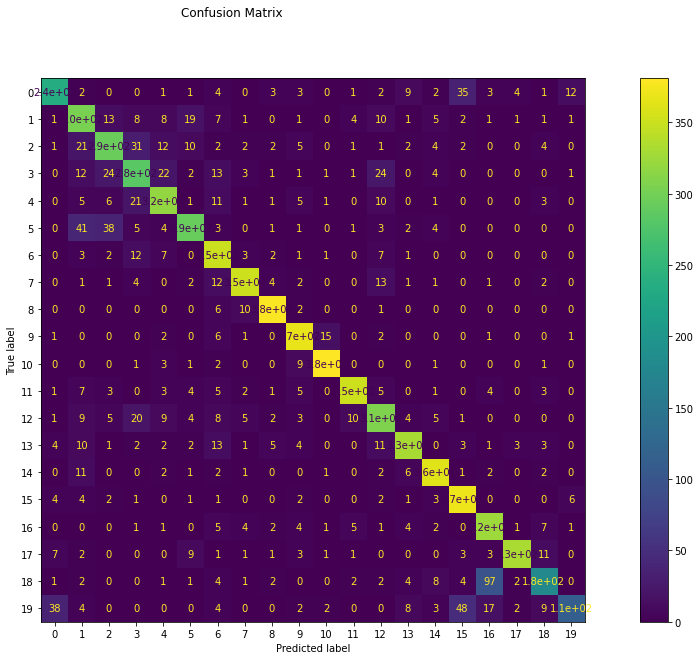

In [6]:
# Test
from sklearn.metrics import accuracy_score

X_test_counts = count_vec.transform(doc_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
label_pred_test = lr_clf.predict(X_test_tfidf)

lr_acc = accuracy_score(label_test, label_pred_test)
print("Test accuracy: {:.2f} %".format(lr_acc * 100))

from sklearn.metrics import plot_confusion_matrix
# Display the testing results
%matplotlib inline
import matplotlib.pyplot as plt

disp = plot_confusion_matrix(lr_clf, X_test_tfidf, label_test)
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches(20, 10)

plt.show()

### Naive Bayes classifier

In [7]:
# Train
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB().fit(X_train_tfidf, label_train)

Test accuracy: 77.39 %


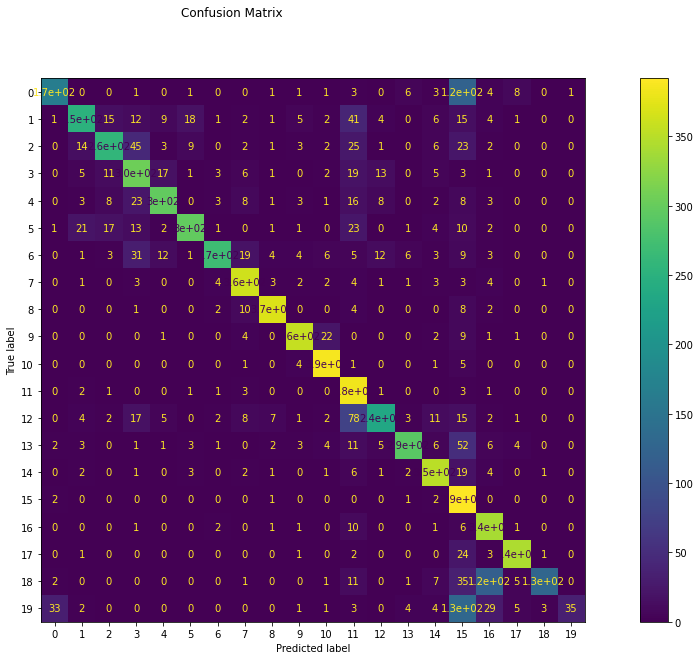

In [8]:
# Test
X_test_counts = count_vec.transform(doc_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
label_pred_test = nb_clf.predict(X_test_tfidf)

lr_acc = accuracy_score(label_test, label_pred_test)
print("Test accuracy: {:.2f} %".format(lr_acc * 100))

# Display the testing results
disp = plot_confusion_matrix(nb_clf, X_test_tfidf, label_test)
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches(20, 10)

plt.show()

### Build a pipeline

## Fine-Tuning: jointly tune three hyperparameters of the whole pipepline

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline


# Build up the decision tree regressor
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),])

# Create a dictionary for all the hyperparameters
hps = {
  'vect__ngram_range': [(1, 1), (1, 2)],
  'tfidf__use_idf': (True, False),
  'clf__alpha': (1, 1e-1, 1e-2),
}

# Transform the performance_metric into a scoring function using 'make_scorer'.
scoring_fnc = make_scorer(accuracy_score)

# Create the grid search cv object (3-fold cross-validation)
grid_search = GridSearchCV(estimator=text_clf, 
                           param_grid=hps, 
                           scoring=scoring_fnc, 
                           cv=3,
                           verbose=5,
                           n_jobs=-1)

# Fit the grid search object to the training data to search the optimal model
grid_search = grid_search.fit(doc_train, label_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.1min finished


In [10]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.830033045064289 {'clf__alpha': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
0.8379879321258711 {'clf__alpha': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
0.7380238708478192 {'clf__alpha': 1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
0.7374931794698597 {'clf__alpha': 1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
0.8926992932894983 {'clf__alpha': 0.1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
0.8920804423706096 {'clf__alpha': 0.1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
0.8565492649668981 {'clf__alpha': 0.1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
0.8584935085800652 {'clf__alpha': 0.1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
0.9045429487880711 {'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
0.9068408616706969 {'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
0.8950858343974814 {'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range

## Retrive the best model

In [11]:
grid_search.best_params_
best_pipeline = grid_search.best_estimator_

# Produce the value for 'max_depth'
print("The best combination of hyperparameters are:")

for hp_name in sorted(hps.keys()):
    print("%s: %r" % (hp_name, grid_search.best_params_[hp_name]))

best_pipeline.fit(doc_train, label_train)
    
# Model prediction on training & test data
label_pred_train = best_pipeline.predict(doc_train)
label_pred_test = best_pipeline.predict(doc_test)

# Display the testing results
train_acc = accuracy_score(label_train, label_pred_train)
test_acc = accuracy_score(label_test, label_pred_test)
print("\nThe prediction accuracy on training set: {:.2f} %".format(train_acc * 100))
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))


The best combination of hyperparameters are:
clf__alpha: 0.01
tfidf__use_idf: True
vect__ngram_range: (1, 2)

The prediction accuracy on training set: 99.92 %
The prediction accuracy on test set: 83.44 %


In [12]:
train_acc = accuracy_score(label_train, label_pred_train)
test_acc = accuracy_score(label_test, label_pred_test)
print("Training Accuracy: {:.2f} %".format(train_acc * 100))
print("Test Accuracy: {:.2f} %".format(test_acc * 100))

Training Accuracy: 99.92 %
Test Accuracy: 83.44 %
